# Lorenzetti Dataset Profiles

In [2]:
import ROOT
from hep_utils.constants import N_RINGS
from hep_utils.root import get_column_names, rdf_to_pandas
from hep_utils import formulas
import hep_utils.plotting.pyplot as hplt
import mplhep as hep
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os
ROOT.EnableImplicitMT()
plt.style.use(hep.style.ROOT)

In [12]:
dataset_dir = '/root/data/2024_08_19_21_18_0000000000_single_electron'
base_filename = "single_electron"
dataset_label = 'electron'
output_dir = os.path.join(dataset_dir, 'plots')
os.makedirs(output_dir, exist_ok=True)
ntuple_filepath = os.path.join(
    dataset_dir,
    'NTUPLE',
    f'{base_filename}.NTUPLE.root'
)
ntuple_rdf = ROOT.RDataFrame('events', ntuple_filepath)
rings_cols = []
for i in range(N_RINGS):
    rings_col_str = f'rings_{i}'
    ntuple_rdf = ntuple_rdf.Define(rings_col_str, f'rings[{i}]')
    rings_cols.append(rings_col_str)
column_names = get_column_names(ntuple_rdf)
ntuple_pdf = rdf_to_pandas(ntuple_rdf, [name for name in column_names if name != 'rings'], nrows=-1)
print(f"DataFrame shape: {ntuple_pdf.shape}")
ntuple_pdf.head()

DataFrame shape: (10000, 147)


,cluster_deta,cluster_dphi,cluster_e,cluster_e0,cluster_e1,cluster_e2,cluster_e233,cluster_e237,cluster_e277,cluster_e2tsts1,...,rings_90,rings_91,rings_92,rings_93,rings_94,rings_95,rings_96,rings_97,rings_98,rings_99
0,0.2,0.2,1.366081e+06,9.367401,134237.828125,1.229096e+06,1.148022e+06,1.176739e+06,1.219020e+06,14667.642578,...,0.000000,-16.621191,24.922503,-13.953091,13.798578,-11.532078,22.841259,14.733897,-31.352837,23.506092
1,0.2,0.2,7.291899e+05,515.850403,21484.021484,6.960901e+05,6.566786e+05,6.705551e+05,6.912972e+05,1792.068237,...,3.071445,0.000000,30.824715,-75.488609,-48.822529,-6.890697,21.374834,-44.835114,-28.084356,-26.383274
2,0.2,0.2,1.425320e+06,-859.940918,136257.609375,1.287073e+06,1.196545e+06,1.237181e+06,1.275962e+06,17595.925781,...,17.564011,0.000000,26.578655,-1.926748,34.838154,-10.234849,11.156988,-8.000655,0.532772,0.000000
3,0.2,0.2,8.337377e+04,-131.621201,42668.800781,4.079198e+04,3.863341e+04,3.963764e+04,4.095484e+04,5830.453125,...,-10.661143,4.011308,194.460495,54.248878,-321.127319,-81.699821,84.375366,-144.654327,67.681999,-1.230418
4,0.2,0.2,7.978003e+05,612.558289,303018.031250,4.934729e+05,4.499005e+05,4.700538e+05,4.873401e+05,52424.625000,...,3.114481,0.000000,9.449740,-45.740479,-48.621410,-22.805244,0.000000,0.000000,0.000000,0.000000


# Event Aggregation

In [5]:
def ntuple_aggregation(df: pd.DataFrame) -> pd.Series:
    n_objects = len(df)
    if n_objects:
        ordered_idxs = df.index[df['cluster_e'].argsort()][::-1]
        highest_e1 = df.loc[ordered_idxs[0], 'cluster_e']
        highest_e2 = df.loc[ordered_idxs[1], 'cluster_e'] if n_objects > 1 else np.nan
        eta1 = df.loc[ordered_idxs[0], 'el_eta']
        eta2 = df.loc[ordered_idxs[1], 'el_eta'] if n_objects > 1 else np.nan
        phi1 = df.loc[ordered_idxs[0], 'el_phi']
        phi2 = df.loc[ordered_idxs[1], 'el_phi'] if n_objects > 1 else np.nan
    else:
        highest_e1 = np.nan
        highest_e2 = np.nan
        eta1 = np.nan
        eta2 = np.nan
        phi1 = np.nan
        phi2 = np.nan
    return pd.Series({
        'n_objects': n_objects,
        'n_duplicates': df.duplicated().sum(),
        'highest_e1': highest_e1,
        'highest_e2': highest_e2,
        'eta1': eta1,
        'eta2': eta2,
        'phi1': phi1,
        'phi2': phi2
    })
filepath = os.path.join(dataset_dir, 'ntuple_grouped_clusters.parquet')
if os.path.exists(filepath):
    ntuple_grouped_clusters = pd.read_parquet(filepath)
else:
    ntuple_grouped_clusters = ntuple_pdf.groupby('event_number').apply(ntuple_aggregation)
    ntuple_grouped_clusters['deltaR'] = formulas.deltaR(ntuple_grouped_clusters['eta1'].values,
                                                    ntuple_grouped_clusters['phi1'].values,
                                                    ntuple_grouped_clusters['eta2'].values,
                                                    ntuple_grouped_clusters['phi2'].values)
    print(f"DataFrame shape: {ntuple_grouped_clusters.shape}")
    ntuple_grouped_clusters.to_parquet(filepath)
ntuple_grouped_clusters.head()

,n_objects,n_duplicates,highest_e1,highest_e2,eta1,eta2,phi1,phi2,deltaR
event_number,,,,,,,,,
0,2.0,0.0,3045082.500,3045082.50,-0.7125,-0.7125,-1.8039,-1.8039,0.000
1,4.0,0.0,3816372.000,3816372.00,-1.2301,-1.2301,1.2272,1.2272,0.000
2,2.0,0.0,2243562.000,2243562.00,0.7625,0.7625,1.0431,1.0431,0.000
3,2.0,0.0,3894693.250,3894693.25,0.8625,0.8625,0.1350,0.1350,0.000
4,2.0,0.0,1438827.875,1109576.75,-1.2875,-1.2625,-2.3194,-2.3194,0.025


# All Rings

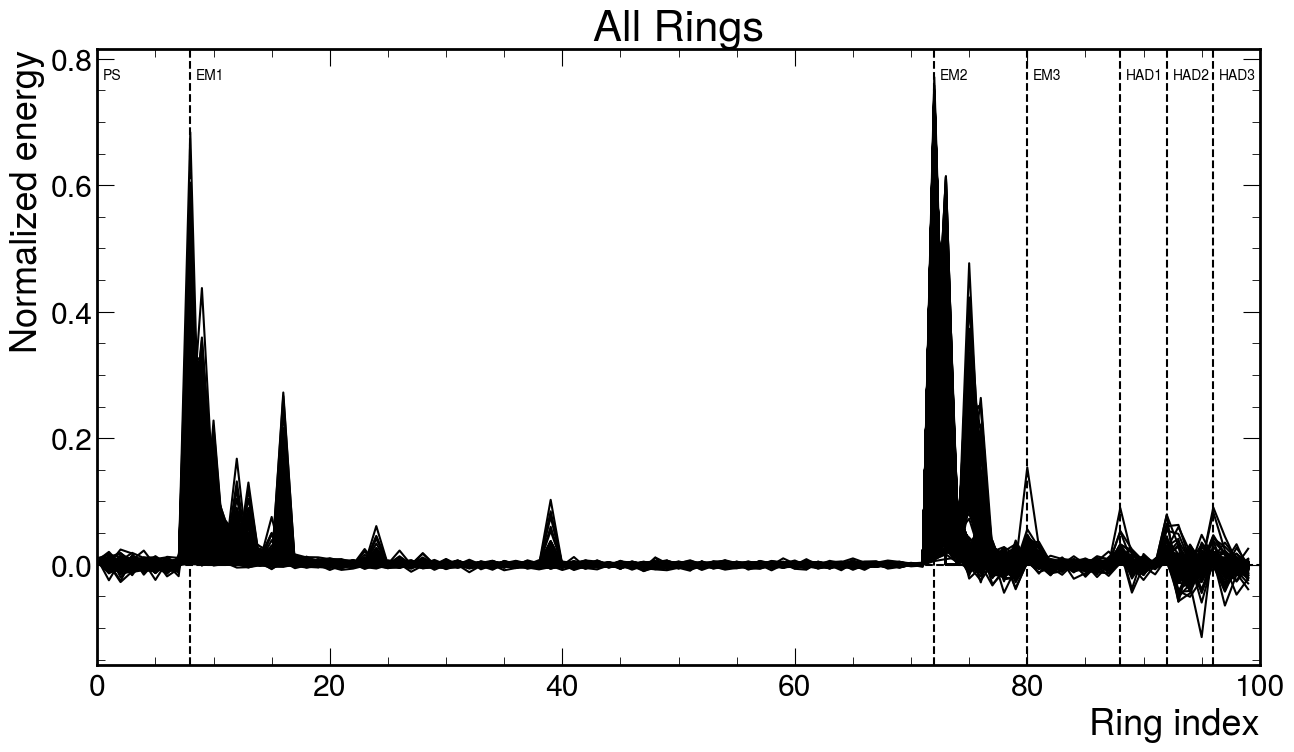

In [13]:
fig, ax = plt.subplots(figsize=(15, 8))
x = np.arange(N_RINGS)
hplt.plot_all_rings(ntuple_pdf[rings_cols], ax, normalize=True, plot_kwargs=dict(color='k'))
fig.savefig(os.path.join(output_dir, 'all_rings.png'), bbox_inches='tight', dpi=300)

# Rings Profile

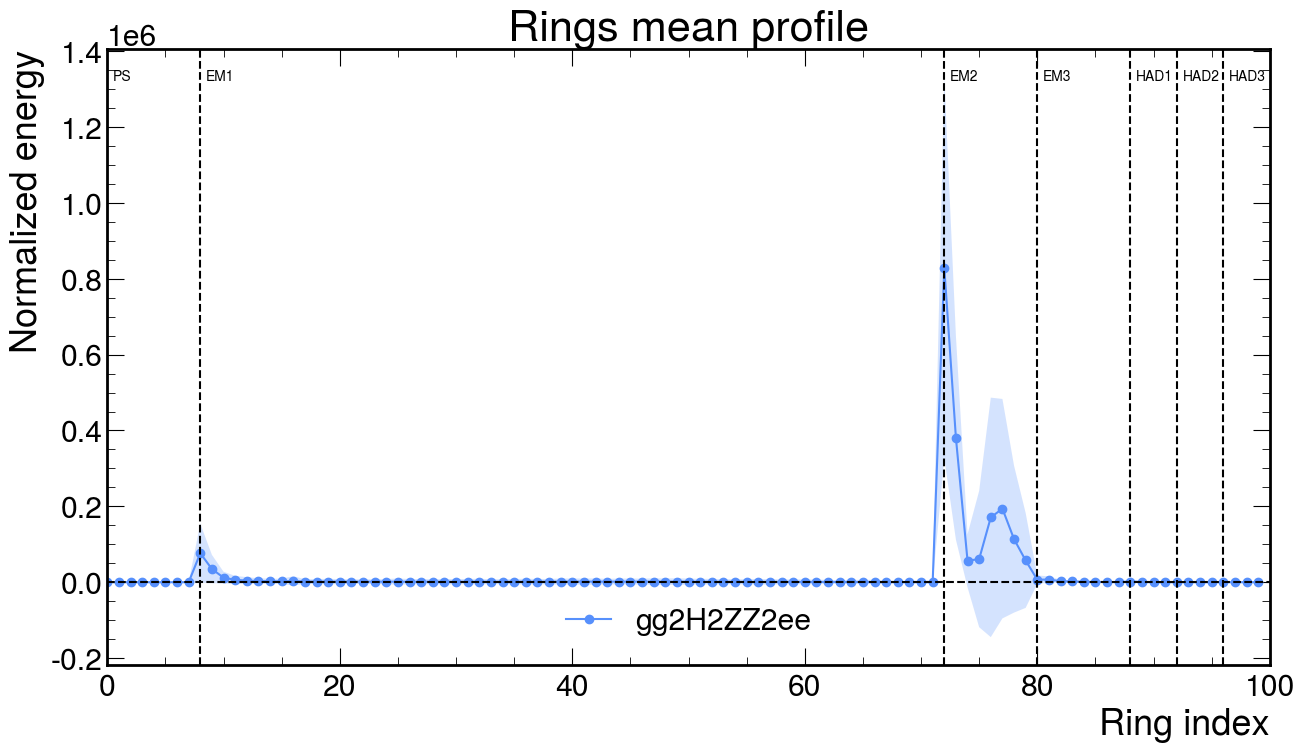

In [6]:
fig, ax = plt.subplots(figsize=(15, 8))
hplt.plot_rings_profile(ntuple_pdf[rings_cols], ax, normalize=True, label=dataset_label)
fig.savefig(os.path.join(output_dir, 'rings_profile_no_normalization.png'), bbox_inches='tight', dpi=300)

# $\Delta R$

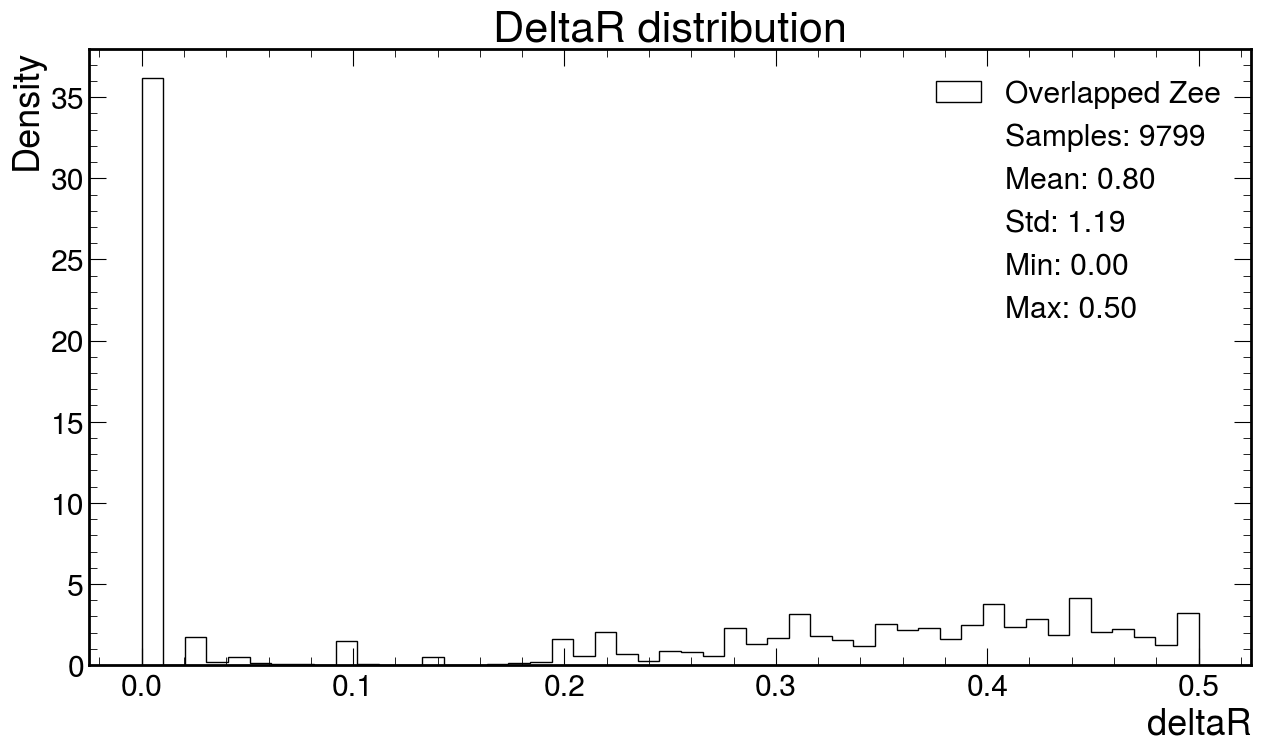

In [9]:
fig, ax = plt.subplots(figsize=(15, 8))
hplt.histplot(
    ntuple_grouped_clusters['deltaR'].dropna(),
    nbins=50,
    ax=ax,
    bin_max=0.5,
    metrics=True,
    ax_set=dict(
        xlabel='deltaR',
        ylabel='Density',
        title='DeltaR distribution',
    ),
    hist_kwargs=dict(
        histtype='step',
        label=dataset_label,
        color='k',
        density=True
    )
)
fig.savefig(os.path.join(output_dir, 'deltaR_distribution_max_0.5.png'), bbox_inches='tight', dpi=300)

# Object distribution

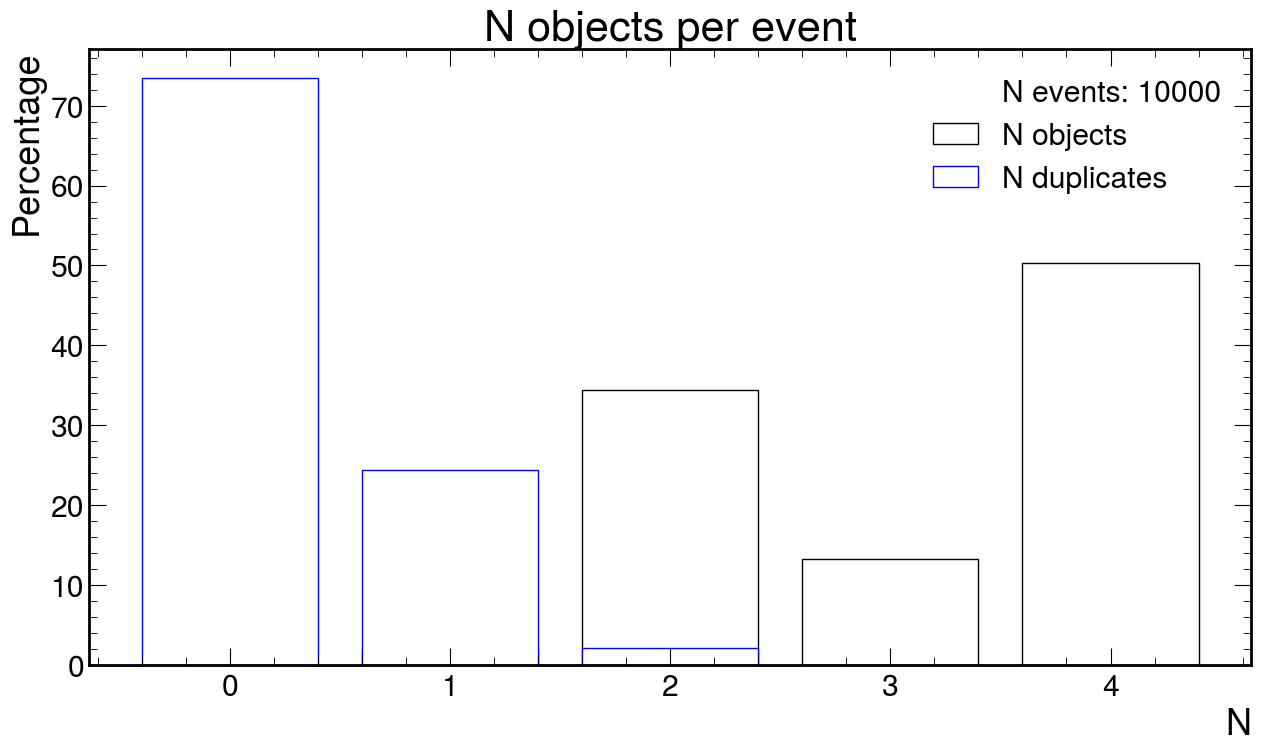

In [6]:
fig, ax = plt.subplots(figsize=(15, 8))
hplt.categorical_histplot(
    ntuple_grouped_clusters['n_objects'].dropna(),
    ax=ax,
    metrics=False,
    percentage=True,
    ax_set=dict(
        xlabel='N',
        ylabel='Percentage',
        title='N objects per event',
    ),
    bar_kwargs=dict(
        label='N objects',
        color='w',
        edgecolor='k'
    )
)
hplt.categorical_histplot(
    ntuple_grouped_clusters['n_duplicates'].dropna(),
    ax=ax,
    metrics=False,
    ax_set=dict(),
    percentage=True,
    bar_kwargs=dict(
        label='N duplicates',
        color='w',
        edgecolor='b'
    )
)
ax.plot([], [], ' ', label=f"N events: {len(ntuple_grouped_clusters)}")
ax.legend()
fig.savefig(os.path.join(output_dir, 'objects_per_event_distribution.png'), bbox_inches='tight', dpi=300)

# Cluster Energy

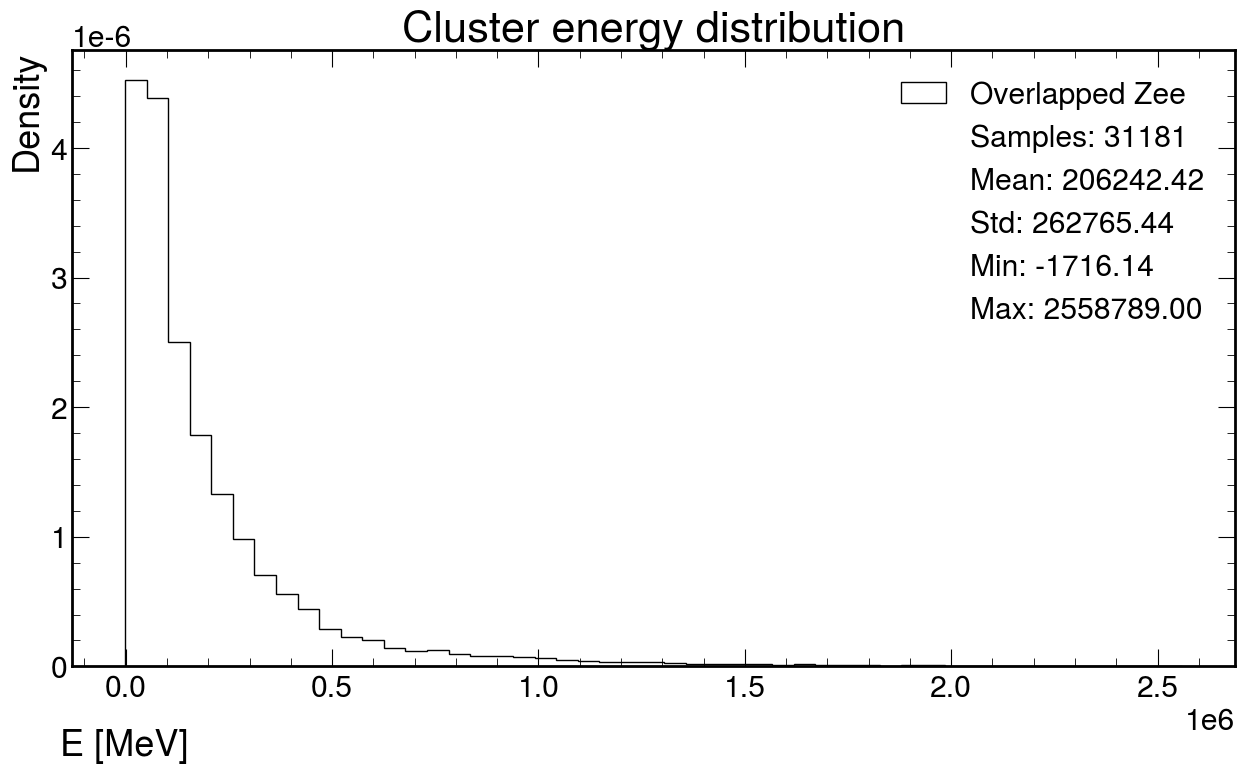

In [7]:
fig, ax = plt.subplots(figsize=(15, 8))
hplt.histplot(
    ntuple_pdf['cluster_e'].dropna(),
    nbins=50,
    ax=ax,
    metrics=True,
    ax_set=dict(
        xlabel='E [MeV]',
        ylabel='Density',
        title='Cluster energy distribution',
    ),
    hist_kwargs=dict(
        histtype='step',
        label=dataset_label,
        color='k',
        density=True
    )
)
ax.xaxis.set_label_coords(0.1, -0.1)
fig.savefig(os.path.join(output_dir, 'cluster_e_distribution.png'), bbox_inches='tight', dpi=300)
fig.savefig(os.path.join(output_dir, 'cluster_e_distribution.pdf'), bbox_inches='tight')